## Anthony Marsilio
<p><b> Professor Binowski / Data Science Programming / April 26th 2023</b></p>

## 
## 
<p><b>In my project I will be focused on whether the city of Bozeman, Montana has better steakhouse reviews or the city of New York.
    I will be pulling 50 reviews from each of these cities and using natural language processing to determine which has a higher proportion of positive-leaning reviews.</b><br></br><b>
    The motivation for this study is to see how physical proximity to choice angus beef (in Bozeman Montana) vs New York City's lack of proximity to such resources is reflected in this environment of Yelp reviews.</b></p>

## 

In [54]:
## importing libraries

import requests
import yelpApiKey as key ## my own .py document containing my personal API key and Client ID
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

## 
## 
<p><b>Here is code from the Yelp Fusion API resource in Github, which I have modified for my project.</b></p>

In [55]:
## libraries
import argparse
import json
import pprint
import requests
import sys
import urllib


# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode


# storing my API Key into a new variable for reference throughout the program
API_KEY = key.apiKEY()


# API constants
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.



## methods for searching and returning information from the Yelp Fusion API
def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
       'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term1, term2, location, radius):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term1.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'categories': term2.replace(' ', '+'),
        'radius': radius,
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

## 
## 
<p><b>Here we run our program for the Montana location (Bozeman, MT). We are doing so with a 24 mile radius from the town center, searching by "dinner" and "steakhouse":</b></p>

In [56]:
## parameters for the Montana steakhouse search
TERM_ONE = 'steakhouse'
TERM_TWO = 'dinner'
DEFAULT_LOCATION = 'Bozeman, MT'
RADIUS = 40000 ## ~24 miles
SEARCH_LIMIT = 50

In [57]:
response = search(API_KEY,TERM_ONE,TERM_TWO, DEFAULT_LOCATION, RADIUS)
response


Querying https://api.yelp.com/v3/businesses/search ...


{'businesses': [{'id': 'xrV_xUiferBkHDqK2CKp3A',
   'alias': 'open-range-mt-bozeman',
   'name': 'Open Range MT',
   'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/UX0HbdvaeKjtQKUE8VN1_Q/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/open-range-mt-bozeman?adjust_creative=LvcO8WtYm8tRcyrA_6wsBg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=LvcO8WtYm8tRcyrA_6wsBg',
   'review_count': 506,
   'categories': [{'alias': 'steak', 'title': 'Steakhouses'},
    {'alias': 'wine_bars', 'title': 'Wine Bars'},
    {'alias': 'cocktailbars', 'title': 'Cocktail Bars'}],
   'rating': 4.0,
   'coordinates': {'latitude': 45.679619, 'longitude': -111.032925},
   'transactions': ['pickup', 'delivery'],
   'price': '$$$',
   'location': {'address1': '241 E Main St',
    'address2': '',
    'address3': '',
    'city': 'Bozeman',
    'zip_code': '59715',
    'country': 'US',
    'state': 'MT',
    'display_address': ['241 E Main St', 'Bozeman, MT 59715']},
   

In [58]:
## initializing counters for TextBlob sentiment results
posBlob = 0
negBlob = 0

posBayes = 0
negBayes = 0

for business in response['businesses']:
    #print(response)
    #print('Business Name: ' + business['name'])
    #print('Rating: ' + str(business['rating']))
    #print('Review Count: ' + str(business['review_count']))
    #print('Reviews: ')
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    #print('https://api.yelp.com/v3/businesses/{}/reviews?limit=20&sort_by=yelp_sort'.format(business['id']))
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        
        # Perform sentiment analysis on the review using TextBlob non-Bayes
        blob = TextBlob(review['text'])
        sentiment = blob.sentiment.polarity
        if sentiment > 0:
            posBlob += 1
        elif sentiment < 0:
            negBlob += 1
            
        blobBayes = TextBlob(review['text'], analyzer = NaiveBayesAnalyzer())
        sentiment = blobBayes.sentiment.classification
        if sentiment == 'pos':
            posBayes += 1
        elif sentiment == 'neg':
            negBayes += 1



Querying https://api.yelp.com/v3/businesses/xrV_xUiferBkHDqK2CKp3A/reviews ...
Querying https://api.yelp.com/v3/businesses/rvuGfi5hNkZQJkd7eqwjew/reviews ...
Querying https://api.yelp.com/v3/businesses/opV5O6T0pNpltHz4F27oAg/reviews ...
Querying https://api.yelp.com/v3/businesses/HiSOFWqyqg05HN2iozPzxg/reviews ...
Querying https://api.yelp.com/v3/businesses/tq8PKf4VS5Loc50BqLhTvg/reviews ...
Querying https://api.yelp.com/v3/businesses/I312dxIo48NEYbtCeaI0Aw/reviews ...
Querying https://api.yelp.com/v3/businesses/iLcs51_RHMRAlmmvlfSJRg/reviews ...
Querying https://api.yelp.com/v3/businesses/P4C-_Nogy8EJG1Mr3q56vg/reviews ...
Querying https://api.yelp.com/v3/businesses/DHyBd6VbgscG5jgnWh-GOw/reviews ...
Querying https://api.yelp.com/v3/businesses/MRDDIa9YlbVD6HpqITl0WQ/reviews ...
Querying https://api.yelp.com/v3/businesses/mSaPc1qcGpKrEZuf1kuRXg/reviews ...
Querying https://api.yelp.com/v3/businesses/gSTJqvWxL7OdOJNtL1z4rA/reviews ...
Querying https://api.yelp.com/v3/businesses/Pa2PvLUe

In [59]:
stringOfReviews = ''
for business in response['businesses']:
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        stringOfReviews += review['text']

Querying https://api.yelp.com/v3/businesses/xrV_xUiferBkHDqK2CKp3A/reviews ...
Querying https://api.yelp.com/v3/businesses/rvuGfi5hNkZQJkd7eqwjew/reviews ...
Querying https://api.yelp.com/v3/businesses/opV5O6T0pNpltHz4F27oAg/reviews ...
Querying https://api.yelp.com/v3/businesses/HiSOFWqyqg05HN2iozPzxg/reviews ...
Querying https://api.yelp.com/v3/businesses/tq8PKf4VS5Loc50BqLhTvg/reviews ...
Querying https://api.yelp.com/v3/businesses/I312dxIo48NEYbtCeaI0Aw/reviews ...
Querying https://api.yelp.com/v3/businesses/iLcs51_RHMRAlmmvlfSJRg/reviews ...
Querying https://api.yelp.com/v3/businesses/P4C-_Nogy8EJG1Mr3q56vg/reviews ...
Querying https://api.yelp.com/v3/businesses/DHyBd6VbgscG5jgnWh-GOw/reviews ...
Querying https://api.yelp.com/v3/businesses/MRDDIa9YlbVD6HpqITl0WQ/reviews ...
Querying https://api.yelp.com/v3/businesses/mSaPc1qcGpKrEZuf1kuRXg/reviews ...
Querying https://api.yelp.com/v3/businesses/gSTJqvWxL7OdOJNtL1z4rA/reviews ...
Querying https://api.yelp.com/v3/businesses/Pa2PvLUe

## 
## 
<p><b>The following takes the Yelp reviews and removes the stop-words, utilizing the nltk library:
    </b></p>

In [60]:
## removing stop words from the entire body of reviews we scraped

from nltk.corpus import stopwords
stops = stopwords.words('english')

## making string into list of words

wordList = stringOfReviews.split()
strippedWordList = []
for word in wordList:
    if word not in stops:
        strippedWordList.append(word)

cleanString = ''
for word in strippedWordList:
    cleanString += " " + word

## 
## 

<p><b>The following is a piece of code to create a wordcloud .png file from the string of the entire 50 Yelp reviews of steakhouses:</b></p>

In [61]:
## this code takes reviews of the new york city steakhouses
## and makes a wordcloud from them and exports that into a .png file

import imageio.v2 as imageio
mask_image = imageio.imread('steak.png')
from wordcloud import WordCloud
wordcloud = WordCloud(colormap = 'prism', mask = mask_image, background_color = 'white')
wordcloud = wordcloud.generate(cleanString)
wordcloud = wordcloud.to_file('steakWordsMT.png')

## 
## 
<p><b>Here we take a visual representation of the two different forms of TextBlob analysis:</b></p>

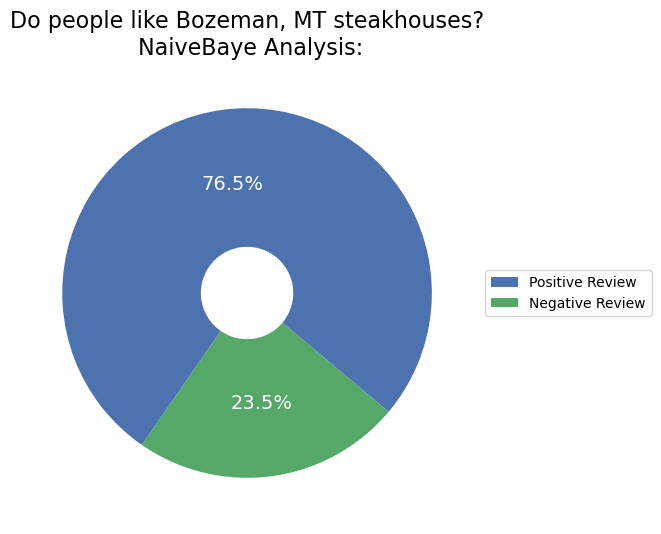

In [62]:
## libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Create data from the information rendered from the Yelp Fusion API calls
## These lines of code were mostly from a chatGPT response, but also include some of my
## own modifications
data = [posBayes, negBayes]
labels = ['Positive', 'Negative']
colors = ['#4C72B0', '#55A868']

# Create donut chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(data, colors=colors, wedgeprops=dict(width=0.75), 
                                  startangle=-40, autopct='%1.1f%%')

# Modifying labels for legend
labels = ['Positive Review', 'Negative Review']

# Add labels to the chart
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(texts, fontsize=12)

# Add percentage labels to wedges
for i, autotext in enumerate(autotexts):
    autotext.set_color('white')
    autotext.set_fontsize(14)


# Add title to the chart
ax.set_title('Do people like Bozeman, MT steakhouses?\n NaiveBaye Analysis:', fontsize=16)




## displaying the charts
plt.show()

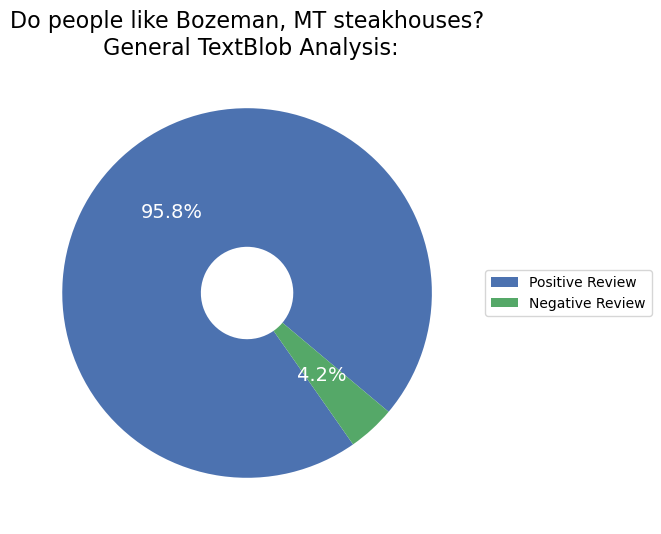

In [63]:
## libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Create data from the information rendered from the Yelp Fusion API calls
## These lines of code were mostly from a chatGPT response, but also include some of my
## own modifications
data = [posBlob, negBlob]
labels = ['Positive', 'Negative']
colors = ['#4C72B0', '#55A868']

# Create donut chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(data, colors=colors, wedgeprops=dict(width=0.75), 
                                  startangle=-40, autopct='%1.1f%%')

# Modifying labels for legend
labels = ['Positive Review', 'Negative Review']

# Add labels to the chart
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(texts, fontsize=12)

# Add percentage labels to wedges
for i, autotext in enumerate(autotexts):
    autotext.set_color('white')
    autotext.set_fontsize(14)
    

# Add title to the chart
ax.set_title('Do people like Bozeman, MT steakhouses?\n General TextBlob Analysis:', fontsize=16)




## displaying the charts
plt.show()

## 
## 
<p><b>Here we run our program for the New York location (NY, NY). We are doing so with a 24 mile radius from the town center, searching by "dinner" and "steakhouse" (just as with the Montana search):</b></p>

In [64]:
## parameters for the New York steakhouse search
TERM_ONE = 'steakhouse'
TERM_TWO = 'dinner'
DEFAULT_LOCATION = 'New York, NY'
RADIUS = 40000 ## ~24 miles
SEARCH_LIMIT = 50

In [65]:
response = search(API_KEY,TERM_ONE,TERM_TWO, DEFAULT_LOCATION, RADIUS)
response

Querying https://api.yelp.com/v3/businesses/search ...


{'businesses': [{'id': '4yPqqJDJOQX69gC66YUDkA',
   'alias': 'peter-luger-brooklyn-2',
   'name': 'Peter Luger',
   'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/d0XSKED0U0sTgFWhCQdY7w/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/peter-luger-brooklyn-2?adjust_creative=LvcO8WtYm8tRcyrA_6wsBg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=LvcO8WtYm8tRcyrA_6wsBg',
   'review_count': 6762,
   'categories': [{'alias': 'steak', 'title': 'Steakhouses'}],
   'rating': 4.0,
   'coordinates': {'latitude': 40.709945, 'longitude': -73.962478},
   'transactions': [],
   'price': '$$$$',
   'location': {'address1': '178 Broadway',
    'address2': '',
    'address3': '',
    'city': 'Brooklyn',
    'zip_code': '11211',
    'country': 'US',
    'state': 'NY',
    'display_address': ['178 Broadway', 'Brooklyn, NY 11211']},
   'phone': '+17183877400',
   'display_phone': '(718) 387-7400',
   'distance': 1446.5330245620685},
  {'id': 'bHattTQoloZeWwLvU

In [66]:
## initializing counters for TextBlob sentiment results
posBlob = 0
negBlob = 0

posBayes = 0
negBayes = 0

for business in response['businesses']:
    #print(response)
    #print('Business Name: ' + business['name'])
    #print('Rating: ' + str(business['rating']))
    #print('Review Count: ' + str(business['review_count']))
    #print('Reviews: ')
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    #print('https://api.yelp.com/v3/businesses/{}/reviews?limit=20&sort_by=yelp_sort'.format(business['id']))
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        
        # Perform sentiment analysis on the review using TextBlob non-Bayes
        blob = TextBlob(review['text'])
        sentiment = blob.sentiment.polarity
        if sentiment > 0:
            posBlob += 1
        elif sentiment < 0:
            negBlob += 1
            
        blobBayes = TextBlob(review['text'], analyzer = NaiveBayesAnalyzer())
        sentiment = blobBayes.sentiment.classification
        if sentiment == 'pos':
            posBayes += 1
        elif sentiment == 'neg':
            negBayes += 1

            

Querying https://api.yelp.com/v3/businesses/4yPqqJDJOQX69gC66YUDkA/reviews ...
Querying https://api.yelp.com/v3/businesses/bHattTQoloZeWwLvUTkRgQ/reviews ...
Querying https://api.yelp.com/v3/businesses/rIk4_cVWtijCso6EBUSbyw/reviews ...
Querying https://api.yelp.com/v3/businesses/b8a-8u_A51v2IzyjLVsx6w/reviews ...
Querying https://api.yelp.com/v3/businesses/A_YpTLbAlEqeLVSs9bxbEA/reviews ...
Querying https://api.yelp.com/v3/businesses/DGhWO1sUWydVeR5j5ZZaMw/reviews ...
Querying https://api.yelp.com/v3/businesses/pQuZDnefX038xurT1BhDXA/reviews ...
Querying https://api.yelp.com/v3/businesses/REDWyPG0UJc5u8iU8mP6Hw/reviews ...
Querying https://api.yelp.com/v3/businesses/8XHbZIKDQbXhyKIGiukVeQ/reviews ...
Querying https://api.yelp.com/v3/businesses/hk3ohp_A4L4UgWTexDxf_Q/reviews ...
Querying https://api.yelp.com/v3/businesses/2eN6if-JFMYKn5DBOrBo5w/reviews ...
Querying https://api.yelp.com/v3/businesses/l2ROlwwJcTPmi_2l3A9oyQ/reviews ...
Querying https://api.yelp.com/v3/businesses/qpkFmGyv

## 
## 
<p><b>Putting reviews into a long string.
    </b></p>

In [67]:
stringOfReviews = ''
for business in response['businesses']:
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        stringOfReviews += review['text']

Querying https://api.yelp.com/v3/businesses/4yPqqJDJOQX69gC66YUDkA/reviews ...
Querying https://api.yelp.com/v3/businesses/bHattTQoloZeWwLvUTkRgQ/reviews ...
Querying https://api.yelp.com/v3/businesses/rIk4_cVWtijCso6EBUSbyw/reviews ...
Querying https://api.yelp.com/v3/businesses/b8a-8u_A51v2IzyjLVsx6w/reviews ...
Querying https://api.yelp.com/v3/businesses/A_YpTLbAlEqeLVSs9bxbEA/reviews ...
Querying https://api.yelp.com/v3/businesses/DGhWO1sUWydVeR5j5ZZaMw/reviews ...
Querying https://api.yelp.com/v3/businesses/pQuZDnefX038xurT1BhDXA/reviews ...
Querying https://api.yelp.com/v3/businesses/REDWyPG0UJc5u8iU8mP6Hw/reviews ...
Querying https://api.yelp.com/v3/businesses/8XHbZIKDQbXhyKIGiukVeQ/reviews ...
Querying https://api.yelp.com/v3/businesses/hk3ohp_A4L4UgWTexDxf_Q/reviews ...
Querying https://api.yelp.com/v3/businesses/2eN6if-JFMYKn5DBOrBo5w/reviews ...
Querying https://api.yelp.com/v3/businesses/l2ROlwwJcTPmi_2l3A9oyQ/reviews ...
Querying https://api.yelp.com/v3/businesses/qpkFmGyv

## 
## 
<p><b>The following takes the Yelp reviews and removes the stop-words, utilizing the nltk library:
    </b></p>

In [68]:
## removing stop words from the entire body of reviews we scraped

from nltk.corpus import stopwords
stops = stopwords.words('english')

## making string into list of words

wordList = stringOfReviews.split()
strippedWordList = []
for word in wordList:
    if word not in stops:
        strippedWordList.append(word)

cleanString = ''
for word in strippedWordList:
    cleanString += " " + word

## 

<p><b>The following is a piece of code to create a wordcloud .png file from the string of the entire 50 Yelp reviews of steakhouses:</b></p>

In [69]:
## this code takes reviews of the new york city steakhouses
## and makes a wordcloud from them and exports that into a .png file

import imageio.v2 as imageio
mask_image = imageio.imread('steak.png')
from wordcloud import WordCloud
wordcloud = WordCloud(colormap = 'prism', mask = mask_image, background_color = 'white')
wordcloud = wordcloud.generate(cleanString)
wordcloud = wordcloud.to_file('steakWordsNY.png')

## 
## 
<p><b>Here we take a visual representation of the two different forms of TextBlob analysis:</b></p>

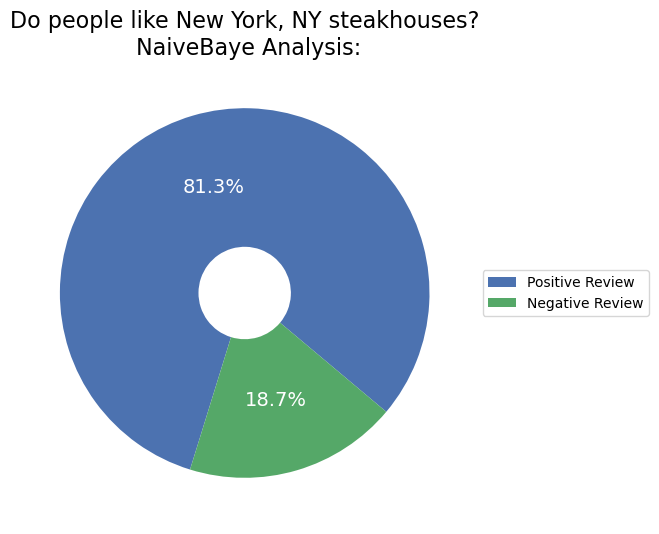

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create data
data = [posBayes, negBayes]
labels = ['Positive', 'Negative']
colors = ['#4C72B0', '#55A868']

# Create donut chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(data, colors=colors, wedgeprops=dict(width=0.75), 
                                  startangle=-40, autopct='%1.1f%%')

# Modifying labels for legend
labels = ['Positive Review', 'Negative Review']

# Add labels to the chart
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(texts, fontsize=12)

# Add percentage labels to wedges
for i, autotext in enumerate(autotexts):
    autotext.set_color('white')
    autotext.set_fontsize(14)
    

# Add title to the chart
ax.set_title('Do people like New York, NY steakhouses?\n NaiveBaye Analysis:', fontsize=16)

# Show the chart
plt.show()

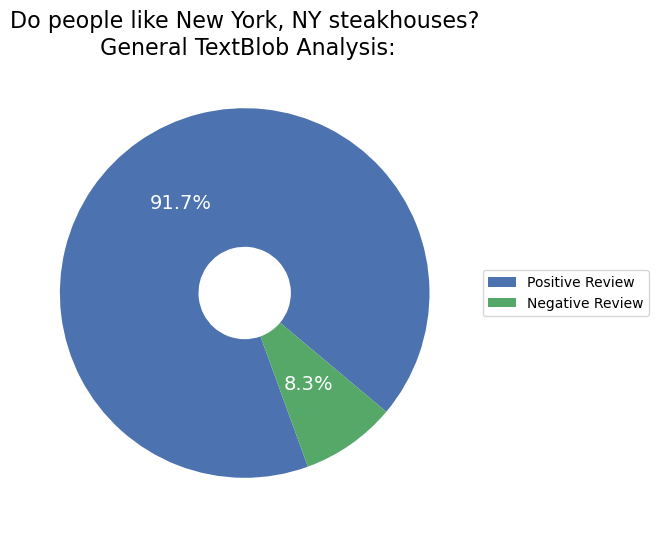

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create data
data = [posBlob, negBlob]
labels = ['Positive', 'Negative']
colors = ['#4C72B0', '#55A868']

# Create donut chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(data, colors=colors, wedgeprops=dict(width=0.75), 
                                  startangle=-40, autopct='%1.1f%%')

# Modifying labels for legend
labels = ['Positive Review', 'Negative Review']

# Add labels to the chart
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(texts, fontsize=12)

# Add percentage labels to wedges
for i, autotext in enumerate(autotexts):
    autotext.set_color('white')
    autotext.set_fontsize(14)
    

# Add title to the chart
ax.set_title('Do people like New York, NY steakhouses?\n General TextBlob Analysis:', fontsize=16)

# Show the chart
plt.show()

## 
## 
<p><b>At a high level, the results of this study show that Bozeman, MT and NY, NY have great steakhouse reviews, with both showing an overwhelming majority (more than 90%) positive reviews.</b></p>

## 
<p><b>To be specific (as seen in the above charts) Bozeman, MT's 24 mile radius has a higher proportion of positive reviews with only 4.3% of reviews showing NEGATIVE. Whereas, New York, NY's 24 mile radius has a slightly lower proportion of positive reviews with 9.9% of reviews showing NEGATIVE.</b></p>

## 
<p><b>In conclusion, it is safe to say these two results are effectively similar considering a small margin of error and some possible reviewer bias. Surely, good steak is available at both of these areas.</b></p>